<a href="https://colab.research.google.com/github/excelasaph/TravelBot---AI-Chatbot/blob/main/travel_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Idea and Setup

My project aims to develop a chatbot specialized in Travel and Geography, capable of providing precise and relevant answers to user questions within this domain. My approach involves fine-tuning a pre-trained Transformer model. To begin, I installed the necessary libraries: `transformers` for utilizing the T5 model as the foundational architecture, `datasets` for efficient data handling, `evaluate` for calculating performance metrics, and `streamlit` planned for the user interface. The setup process also includes verifying GPU availability, which is essential for accelerating model training.

## Load and preprocess data

For this Travel and Geography domain specific chatbot, I am using the dataset from Hugging Face titled "[BAAI/IndustryInstruction_Travel-Geography](https://huggingface.co/datasets/BAAI/IndustryInstruction_Travel-Geography)". This dataset, curated by the Beijing Academy of Artificial Intelligence (BAAI), is in English and Chinese and contains conversational data focused on travel and geography. It is part of a larger collection designed for instruction-following tasks.

The raw data is processed in the subsequent steps to extract query-response pairs suitable for fine-tuning a generative model.

This section below focuses on loading the raw dataset, filtering it to include only English conversations related to travel and geography, sampling a subset of 20,000 entries, and applying preprocessing steps. The preprocessing includes normalizing text by converting to lowercase, removing punctuation, and lemmatizing words. It also involves extracting query-response pairs from the conversational data and formatting them into 'input_text' and 'target_text' columns suitable for a T5 model.

In [ ]:
# Execute the installation cell
!pip install --upgrade transformers datasets evaluate streamlit
!pip install rouge_score

# Execute the necessary import and setup cells
import os
import re
import string

import tensorflow as tf
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Specific module/function imports
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Enabling GPU with memory growth before any TF operations
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled with memory growth:", physical_devices)
    except:
        print("Failed to set memory growth, falling back to CPU")
        tf.config.set_visible_devices([], 'GPU')
else:
    print("No GPU found, using CPU")


# Now executing the data loading and preprocessing steps

# Load dataset
dataset = load_dataset("BAAI/IndustryInstruction_Travel-Geography", split="train")
df = pd.DataFrame(dataset)

# Filter for English and sample 20,000 rows
df = df[df['lang'] == 'en'].sample(n=20000, random_state=42)

# Initialize NLTK lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map POS tags for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word], tagset='averaged_perceptron_tagger_eng')[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Normalize text
def normalize_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    return ' '.join(lemmatized)

# Reconfirm GPU memory growth
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth reconfirmed (T4)")
    except:
        print("GPU memory growth reconfirm failed, falling back to CPU")

# Extract query-response pairs
def extract_pairs(convo):
    if len(convo) >= 2 and convo[0]['from'] == 'human' and convo[1]['from'] == 'gpt':
        return convo[0]['value'], convo[1]['value']
    return None, None

df[['query', 'response']] = df['conversations'].apply(lambda x: pd.Series(extract_pairs(x)))

# Drop missing pairs
df = df.dropna(subset=['query', 'response'])

# Normalize text
df['query_clean'] = df['query'].apply(normalize_text)
df['response_clean'] = df['response'].apply(normalize_text)

# Format for T5
df['input_text'] = 'question: ' + df['query'] + ' answer:'
df['target_text'] = df['response']

# Create the data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Save preprocessed data
df.to_csv('data/preprocessed_travel_geography_20k.csv', index=False)
print(f"Processed {len(df)} English pairs (target: 20,000).")

display(df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 157.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 2

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=78d6c211f68114e81d4ad5fe3f732aab616adcbb679fb9c42badd9890bcce0df
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


GPU enabled with memory growth: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


industry_instruction_semantic_cluster_de(…):   0%|          | 0.00/134M [00:00<?, ?B/s]

(…)B8%B8_%E5%9C%B0%E7%90%86_valid_val.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/137354 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/138354 [00:00<?, ? examples/s]

GPU memory growth reconfirmed (T4)
Processed 20000 English pairs (target: 20,000).


,deita_score,rw_score,id,instruction,lang,length,conversations,query,response,query_clean,response_clean,input_text,target_text
79098,16.169227,-11.875000,generate_from_given_text,,en,29,"[{'from': 'human', 'value': 'What role does th...",What role does the Anqing Museum play in educa...,The Anqing Museum is dedicated to educating th...,what role doe the anqing museum play in educat...,the anqing museum is dedicated to educating th...,question: What role does the Anqing Museum pla...,The Anqing Museum is dedicated to educating th...
27591,9.875659,-9.250000,generate_from_given_text,,en,17,"[{'from': 'human', 'value': 'Can you summarize...",Can you summarize the history of Dongping Lake...,"Dongping Lake, known as Liangerwa, Dayezhai, J...",can you summarize the history of dongping lake...,dongping lake known a liangerwa dayezhai juyez...,question: Can you summarize the history of Don...,"Dongping Lake, known as Liangerwa, Dayezhai, J..."
15263,11.468480,-24.250000,generate_from_given_text,,en,27,"[{'from': 'human', 'value': 'Describe the loca...",Describe the location chosen for the starting ...,The starting point of the sightseeing train pr...,describe the location chosen for the starting ...,the starting point of the sightseeing train pr...,question: Describe the location chosen for the...,The starting point of the sightseeing train pr...
55684,11.468305,-2.140625,generate_from_given_text,,en,22,"[{'from': 'human', 'value': 'Can you summarize...",Can you summarize the main differences between...,Resort hotels in the tourism era were typicall...,can you summarize the main difference between ...,resort hotel in the tourism era were typically...,question: Can you summarize the main differenc...,Resort hotels in the tourism era were typicall...
51848,9.094774,-21.125000,generate_from_given_text,,en,33,"[{'from': 'human', 'value': 'What are the thre...",What are the three main strategies suggested i...,The three main strategies suggested in the tex...,what are the three main strategy suggested in ...,the three main strategy suggested in the text ...,question: What are the three main strategies s...,The three main strategies suggested in the tex...


## Tokenize data and create hugging face datasets


Here, the preprocessed data is split into training (80%) and validation (20%) sets. The T5 tokenizer is initialized. The tokenize_function is applied to both training and validation data to convert the text inputs and targets into token IDs and attention masks, padding sequences to a maximum length of 512. The tokenized data is then converted into Hugging Face Dataset objects (train_dataset_hf and val_dataset_hf), which I used for training with the Hugging Face Trainer.

In [ ]:
# Load preprocessed data
df = pd.read_csv('data/preprocessed_travel_geography_20k.csv')

# Split data (80/20)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(len(train_df), len(val_df))

# Initialize tokenizer
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Tokenize the data
def tokenize_function(examples):
    inputs = examples['input_text']
    targets = examples['target_text']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=512, truncation=True, padding='max_length').input_ids
    model_inputs["labels"] = labels
    return model_inputs

# Applying tokenization and convert to list of dictionaries
train_tokenized = list(train_df.apply(tokenize_function, axis=1))
val_tokenized = list(val_df.apply(tokenize_function, axis=1))

# Converting to Hugging Face Dataset format
from datasets import Dataset
train_dataset_hf = Dataset.from_list(train_tokenized)
val_dataset_hf = Dataset.from_list(val_tokenized)

# Removed TensorFlow dataset conversion

print("Tokenization and Hugging Face Dataset creation complete.")

16000 4000
Tokenization and Hugging Face Dataset creation complete.


## Word Cloud

Separate word clouds are generated to highlight the prominent terms in each. `Word Cloud for Queries`and `Word Cloud for Responses`. These will highlight the common terms and phrases used in the queries and responses provided by the chatbot

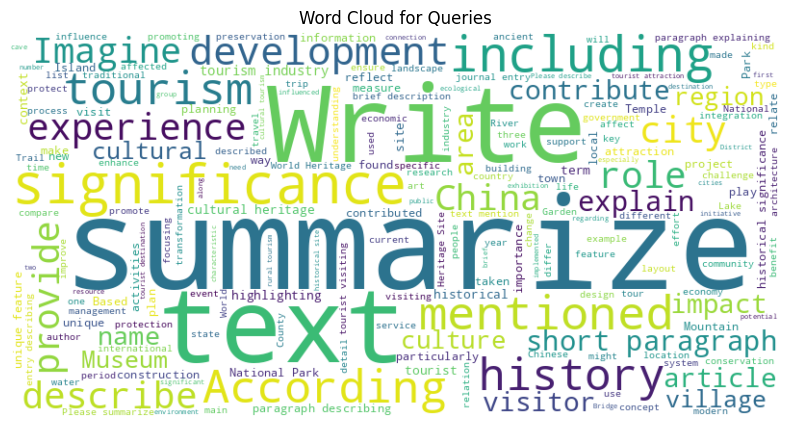

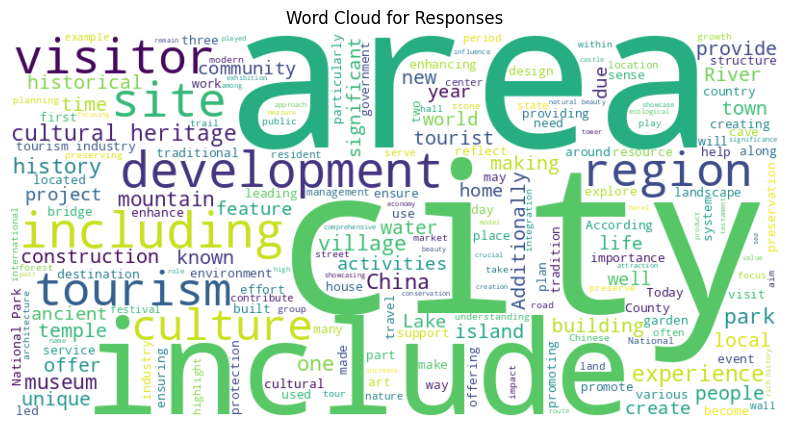

In [ ]:
# Combining all queries into a single string
query_text = ' '.join(train_df['query'].astype(str))

# Generate the word cloud for queries
wordcloud_queries = WordCloud(width=800, height=400, background_color='white').generate(query_text)

# Display the word cloud for queries
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_queries, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Queries')
plt.show()

# Combining all responses into a single string
response_text = ' '.join(train_df['response'].astype(str))

# Generate the word cloud for responses
wordcloud_responses = WordCloud(width=800, height=400, background_color='white').generate(response_text)

# Display the word cloud for responses
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_responses, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Responses')
plt.show()

## Load pytorch model and tokenizer




In this step, the PyTorch version of the T5 model is loaded from the Hugging Face Hub

In [ ]:
# Check if tokenizer is initialized
if 'tokenizer' in locals() and isinstance(tokenizer, T5Tokenizer):
    print("Tokenizer initialized successfully.")
else:
    print("Tokenizer not initialized or not a T5Tokenizer instance.")

# Load T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Verifying that the model is created and is a PyTorch T5ForConditionalGeneration instance
if 'model' in locals() and isinstance(model, T5ForConditionalGeneration):
    print("PyTorch T5ForConditionalGeneration model loaded successfully.")
else:
    print("Model not loaded or not a PyTorch T5ForConditionalGeneration instance.")


Tokenizer initialized successfully.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

PyTorch T5ForConditionalGeneration model loaded successfully.


## Define training arguments


Here, I defined the TrainingArguments object, which configures various hyperparameters and settings for the training process when using the Hugging Face Trainer.

Key parameters set include the output directory for saving checkpoints and logs, the number of training epochs (set to 3), batch sizes for training and evaluation (set to 8), warmup steps for the learning rate scheduler, weight decay, and logging/evaluation/save strategies (set to 'epoch').

In [ ]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch", # Save checkpoint every epoch
    load_best_model_at_end=True, # Load the best model when training ends
)

## Initialize and run trainer



In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_hf,
    eval_dataset=val_dataset_hf,
    tokenizer=tokenizer,
)

# Start training
trainer.train()

/tmp/ipython-input-1976520763.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: obolo-emmanuel31052000 (obolo-emmanuel31052000-african-leadership-academy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.675300,0.602064
2,0.538600,0.589393
3,0.756300,0.585995


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=6000, training_loss=0.8656605004469554, metrics={'train_runtime': 3548.5684, 'train_samples_per_second': 13.527, 'train_steps_per_second': 1.691, 'total_flos': 2.922997874688e+16, 'train_loss': 0.8656605004469554, 'epoch': 3.0})

## Save model

In [ ]:
# Saving the pretrained model and tokenizer
model.save_pretrained("fine_tuned_t5_travel_geography")
tokenizer.save_pretrained("fine_tuned_t5_travel_geography")

('fine_tuned_t5_travel_geography/tokenizer_config.json',
 'fine_tuned_t5_travel_geography/special_tokens_map.json',
 'fine_tuned_t5_travel_geography/spiece.model',
 'fine_tuned_t5_travel_geography/added_tokens.json')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

drive_save_path = '/content/drive/My Drive/fine_tuned_models/fine_tuned_t5_travel_geography.zip'

# Saving the zipped model directly to Google Drive
!zip -r "$drive_save_path" fine_tuned_t5_travel_geography/

Mounted at /content/drive
  adding: fine_tuned_t5_travel_geography/ (stored 0%)
  adding: fine_tuned_t5_travel_geography/spiece.model (deflated 48%)
  adding: fine_tuned_t5_travel_geography/tokenizer_config.json (deflated 94%)
  adding: fine_tuned_t5_travel_geography/generation_config.json (deflated 27%)
  adding: fine_tuned_t5_travel_geography/special_tokens_map.json (deflated 85%)
  adding: fine_tuned_t5_travel_geography/added_tokens.json (deflated 83%)
  adding: fine_tuned_t5_travel_geography/config.json (deflated 63%)
  adding: fine_tuned_t5_travel_geography/model.safetensors (deflated 8%)


## Plot training history

This plot visualizes how the model's performance (measured by loss) changed during training on both the training and validation datasets, helping to assess convergence and identify potential overfitting.

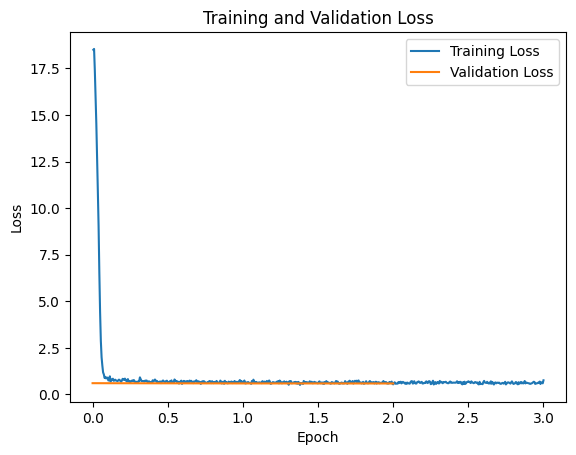

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

# Extracting loss and validation loss from trainer logs
train_loss = []
val_loss = []
epochs = []

for log_entry in trainer.state.log_history:
    if 'loss' in log_entry and 'learning_rate' in log_entry:
        train_loss.append(log_entry['loss'])
        epochs.append(log_entry['epoch'])
    elif 'eval_loss' in log_entry:
        val_loss.append(log_entry['eval_loss'])


plt.plot(epochs, train_loss, label='Training Loss')

if len(val_loss) == len(train_loss):
    plt.plot(epochs, val_loss, label='Validation Loss')
elif len(val_loss) > 0:
     plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluating model


In [ ]:
import torch

# Loading the preprocessed data
df = pd.read_csv('data/preprocessed_travel_geography_20k.csv')

# Take the first row as an example
sample_input_text = df['input_text'].iloc[0]
sample_target_text = df['target_text'].iloc[0]

print(f"Sample Input Text: {sample_input_text}")
print(f"Sample Target Text: {sample_target_text}")

# Tokenize the input text
inputs = tokenizer(sample_input_text, return_tensors='pt')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}


# Generate a response using the fine-tuned model
# Using beam search for potentially better output

output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=128,
    num_beams=4,
    early_stopping=True
)

# Decode the generated output
generated_response = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"\nGenerated Response from Fine-tuned T5-base:")
print(generated_response)

Sample Input Text: question: What role does the Anqing Museum play in educating the public and promoting cultural heritage, and how does it balance academic research with visitor engagement? answer:
Sample Target Text: The Anqing Museum is dedicated to educating the public and promoting cultural heritage through its comprehensive approach. It balances academic research and visitor engagement by presenting artifacts and exhibits in an accessible and interactive manner. The museum's 8 exhibition halls utilize a range of media, including sculptures, charts, paintings, scene restorations, models, multimedia presentations, and live performances, to create a vibrant and dynamic learning experience. The museum's role in research is reflected in its collection of historical artifacts and the scholarly studies they inspire. At the same time, its visitor-focused approach ensures that the museum is not only a center for academic study but also a place for community members and tourists to appreci

## Sample predictions


The original input text, target text, and the model's predicted text for 128 samples are collected and saved to a CSV file `predictions_sample_128.csv` for qualitative review.

In [ ]:
import pandas as pd
import torch

num_samples = 128

# Taking the first num_samples examples for simplicity
sample_val_dataset = val_dataset_hf.select(range(num_samples))

# Need to load the original val_df if not already in memory
if 'val_df' not in locals():
    df_full = pd.read_csv('data/preprocessed_travel_geography_20k.csv')
    _, val_df = train_test_split(df_full, test_size=0.2, random_state=42)

sample_input_texts = val_df['input_text'].iloc[:num_samples].tolist()
sample_target_texts = val_df['target_text'].iloc[:num_samples].tolist()


# Generate predictions for the sample
def generate_predictions_for_sample(dataset_slice, model, tokenizer):
    predictions = []
    # Processes in batches
    batch_size = 8
    for i in range(0, len(dataset_slice), batch_size):
        batch = dataset_slice[i:i+batch_size]

        input_ids = torch.tensor(batch['input_ids']).to(model.device)
        attention_mask = torch.tensor(batch['attention_mask']).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128,
                num_beams=4,
                early_stopping=True
            )
        predictions.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    return predictions

# Ensuring model is on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

sample_predictions = generate_predictions_for_sample(sample_val_dataset, model, tokenizer)


# Creating a pandas DataFrame
sample_results_df = pd.DataFrame({
    'Input Text': sample_input_texts,
    'Target Text': sample_target_texts,
    'Predicted Text': sample_predictions
})

# Defining the output file path
output_csv_path = 'metrics/predictions_sample_128.csv'

# Saving the DataFrame to a CSV file
sample_results_df.to_csv(output_csv_path, index=False)

print(f"Sample predictions saved to {output_csv_path}")
display(sample_results_df.head())

Sample predictions saved to metrics/predictions_sample_128.csv


,Input Text,Target Text,Predicted Text
0,question: What specific strategies has the tow...,Baxiangshan has implemented several strategies...,Baxiangshan has implemented a series of strate...
1,question: Can you summarize the author's advic...,"The author advises not to rush, to avoid plann...",The author's advice for planning a tour of sev...
2,question: The text refers to Chengdu's efforts...,The Chengdu Administration for Industry and Co...,"Chengdu's efforts in creating a ""reassuring an..."
3,question: Write a short paragraph describing a...,"The hypothetical urban heritage project, ""Revi...",A hypothetical urban heritage project that inc...
4,question: Could you summarize the main objecti...,"The ""Silk Road Book Series"" (丝书) is an ambitio...",The main objectives and expected outcomes of t...


## ROUGE and BERT Score Metrics


`ROUGE` measures the overlap of n-grams between the generated and reference texts, while `BERT Score` measures the semantic similarity using BERT embeddings. The calculated scores provides objective measures of the model's generation quality compared to the target responses

In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.3 MB/s eta 0:00:00


## Evaluate the model using ROUGE and BERT Score metrics

In [ ]:
# Evaluating the model using ROUGE and BERTScore metrics

import evaluate
import numpy as np
import torch

# Load metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Generate predictions for evaluation
def generate_predictions(batch):
    input_ids = torch.tensor(batch['input_ids']).to(model.device)
    attention_mask = torch.tensor(batch['attention_mask']).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Generate predictions for the validation dataset
predictions = []
references = []
batch_size = 8

for i in range(0, len(val_dataset_hf), batch_size):
    batch = val_dataset_hf[i:i+batch_size]
    predictions.extend(generate_predictions(batch))
    if 'val_df' not in locals():
         df_full = pd.read_csv('data/preprocessed_travel_geography_20k.csv')
         _, val_df = train_test_split(df_full, test_size=0.2, random_state=42)

    references.extend(val_df['target_text'].iloc[i:i+batch_size].tolist())


# Compute ROUGE scores
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("ROUGE Scores:")
print(rouge_scores)

# Compute BERTScore
bertscore_scores = bertscore.compute(predictions=predictions, references=references, lang="en")

# BERTScore returns precision, recall, and f1 for each example
avg_bertscore = {
    "precision": np.mean(bertscore_scores['precision']),
    "recall": np.mean(bertscore_scores['recall']),
    "f1": np.mean(bertscore_scores['f1'])
}
print("\nAverage BERTScore:")
print(avg_bertscore)


ROUGE Scores:
{'rouge1': np.float64(0.3814416499616997), 'rouge2': np.float64(0.18239392538275095), 'rougeL': np.float64(0.29580137514806654), 'rougeLsum': np.float64(0.2988927491197754)}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Average BERTScore:
{'precision': np.float64(0.8892960347235203), 'recall': np.float64(0.8646559206992388), 'f1': np.float64(0.8765477740466595)}


BLEU score, another common metric for evaluating the quality of generated text, compares the model's predictions against the reference responses from the validation set.

BLEU measures the n-gram overlap and considers a brevity penalty

In [ ]:
# Calculate BLEU and ROUGE scores

import evaluate

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

if 'predictions' in globals() and 'references' in globals():
    references_for_bleu = [[r] for r in references]

    # Compute BLEU score
    bleu_score = bleu.compute(predictions=predictions, references=references_for_bleu)
    print("BLEU Score:", bleu_score)

    # Compute ROUGE score
    rouge_score = rouge.compute(predictions=predictions, references=references)
    print("\nROUGE Score:", rouge_score)
else:
    print("Predictions and references not found. Please run the evaluation cell (oDvxf_bhtFlb) first.")

BLEU Score: {'bleu': 0.10877346483351724, 'precisions': [0.4649309695306492, 0.19848442564884186, 0.11946003237773051, 0.08319766628115124], 'brevity_penalty': 0.6250442895445497, 'length_ratio': 0.6803032230042498, 'translation_length': 283498, 'reference_length': 416723}

ROUGE Score: {'rouge1': np.float64(0.3814416499616997), 'rouge2': np.float64(0.18239392538275095), 'rougeL': np.float64(0.29580137514806654), 'rougeLsum': np.float64(0.2988927491197754)}


## Save metric results


In [ ]:
# Saving the metrics results

import json
import os
import pandas as pd

# Creating a directory to save metrics if it doesn't exist
if not os.path.exists('metrics'):
    os.makedirs('metrics')

# Defining the file paths
metrics_json_file_path = 'metrics/evaluation_metrics.json'
metrics_csv_file_path = 'metrics/evaluation_metrics.csv'

metrics_to_save = {}

if 'rouge_scores' in globals():
    metrics_to_save["rouge_scores"] = {k: float(v) for k, v in rouge_scores.items()}

if 'avg_bertscore' in globals():
    metrics_to_save["avg_bertscore"] = {k: float(v) for k, v in avg_bertscore.items()}

if 'bleu_score' in globals():
    metrics_to_save["bleu_score"] = {k: float(v) if not isinstance(v, list) else v for k, v in bleu_score.items()}


# Saving the metrics to a JSON file
with open(metrics_json_file_path, 'w') as f:
    json.dump(metrics_to_save, f, indent=4)

print(f"Evaluation metrics saved to {metrics_json_file_path}")

# Converting metrics to a pandas DataFrame and save as CSV
flattened_metrics = {}
for metric_type, scores in metrics_to_save.items():
    for score_name, score_value in scores.items():
        if isinstance(score_value, list):
             flattened_metrics[f"{metric_type}_{score_name}"] = [str(score_value)]
        else:
            flattened_metrics[f"{metric_type}_{score_name}"] = [score_value]


metrics_df = pd.DataFrame(flattened_metrics)

# Saving the DataFrame to a CSV file
metrics_df.to_csv(metrics_csv_file_path, index=False)

print(f"Evaluation metrics saved to {metrics_csv_file_path}")

Evaluation metrics saved to metrics/evaluation_metrics.json
Evaluation metrics saved to metrics/evaluation_metrics.csv


## Out-of-Domain Check

An out-of-domain check that uses a simple heuristic (checking if the generated response is shorter than a threshold length) to guess if a query might be out-of-domain

In [ ]:
# Out-of-Domain Check

def is_out_of_domain(generated_response, threshold_length=20):
    """
    A very basic heuristic to check if a generated response might be out-of-domain.
    Checks if the response is shorter than a threshold length.
    NOTE: This is NOT a reliable method for out-of-domain detection.
    """
    # Example heuristic: Checking if the response is very short
    return len(generated_response.split()) < threshold_length

def generate_response_with_ood_check(input_text, model, tokenizer, threshold_length=20):
    """
    Generates a response and performs a basic out-of-domain check.
    """
    inputs = tokenizer(input_text, return_tensors='pt').to(model.device)

    with torch.no_grad():
        output = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

    generated_response = tokenizer.decode(output[0], skip_special_tokens=True)

    if is_out_of_domain(generated_response, threshold_length):
        return "I can only answer questions about travel and geography. Please ask a question related to that topic."
    else:
        return generated_response

# Example of using the function with an in-domain query
in_domain_query = "What are the major rivers in the Amazon basin?"
response_in_domain = generate_response_with_ood_check(in_domain_query, model, tokenizer)
print(f"In-domain Query: {in_domain_query}")
print(f"Generated Response (with check): {response_in_domain}")

print("-" * 30)

# Example of using the function with a potentially out-of-domain query
out_of_domain_query = "What is the capital of France?" # Example out-of-domain query
response_out_of_domain = generate_response_with_ood_check(out_of_domain_query, model, tokenizer)
print(f"Out-of-domain Query: {out_of_domain_query}")
print(f"Generated Response (with check): {response_out_of_domain}")

In-domain Query: What are the major rivers in the Amazon basin?
Generated Response (with check): The major rivers in the Amazon basin are the Amazon River, the Amazon River, the Amazon River, the Amazon River, and the Amazon River.
------------------------------
Out-of-domain Query: What is the capital of France?
Generated Response (with check): I can only answer questions about travel and geography. Please ask a question related to that topic.


## Qualitative Testing

Testing out a manual assessment of the model's ability to generate meaningful and relevant responses across different types of inputs.

In [ ]:
# More Qualitative Testing

def test_chatbot(queries, model, tokenizer, device):
    """
    Tests the fine-tuned chatbot with a list of queries and prints the responses.
    """
    for query in queries:
        print(f"Query: {query}")
        inputs = tokenizer(query, return_tensors='pt').to(device)

        with torch.no_grad():
            output = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                num_beams=4,
                early_stopping=True
            )

        generated_response = tokenizer.decode(output[0], skip_special_tokens=True)
        print(f"Response: {generated_response}\n")

# A list of sample queries for testing
sample_queries = [
    "Tell me about the geography of the Himalayas.", # In-domain
    "What is the capital of Australia?", # In-domain
    "Describe the Great Barrier Reef.", # In-domain
    "What is the formula for water?", # Out-of-domain
    "Who won the last Super Bowl?", # Out-of-domain
    "What are the best hiking trails in Patagonia?", # In-domain
    "Explain the concept of photosynthesis.", # Out-of-domain
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Run the qualitative tests
print("Performing Qualitative Testing:")
test_chatbot(sample_queries, model, tokenizer, device)

Performing Qualitative Testing:
Query: Tell me about the geography of the Himalayas.
Response: Tell me about the geography of the Himalayas. The Himalayas are located in the Himalayas and are surrounded by mountains and valleys. The Himalayas are characterized by high altitudes, high altitudes, and low altitudes. The Himalayas are characterized by high altitudes, high altitudes, and low altitudes. The Himalayas are characterized by high altitudes, high altitudes, and low altitudes. The Himalayas are characterized by high altitudes, high altitudes, and low altitudes

Query: What is the capital of Australia?
Response: The capital of Australia is Sydney.

Query: Describe the Great Barrier Reef.
Response: Describe the Great Barrier Reef.

Query: What is the formula for water?
Response: What is the formula for water?

Query: Who won the last Super Bowl?
Response: Who won the last Super Bowl?

Query: What are the best hiking trails in Patagonia?
Response: The best hiking trails in Patagonia 

## Simple ChatBot Interaction

A simple interactive chatbot interface that prompts the user for input. The user's query is then passed to the fine-tuned model to generate a response. The generated response is printed back to the user.

The interaction continues until the user types 'stop'.

In [ ]:
# Simple Chatbot Interaction

def chatbot_interaction():
    print("Hello! I'm a travel and geography chatbot. Ask me anything about travel or geography. Type 'stop' to end the conversation.")
    # Ensuring both model and tokenizer are available and on the correct device
    if 'model' not in globals() or 'tokenizer' not in globals():
        print("Error: Model or tokenizer not loaded. Please run the model loading cells first.")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    while True:
        user_input = input("You: ")
        if user_input.lower() == 'stop':
            print("Chatbot: Goodbye!")
            break

        if 'generate_response_with_ood_check' in globals():
             response = generate_response_with_ood_check(user_input, model, tokenizer)
        else:
             # Fallback to simple generation if OOD check function is not defined
             inputs = tokenizer(user_input, return_tensors='pt').to(device)
             with torch.no_grad():
                 output = model.generate(
                     inputs['input_ids'],
                     attention_mask=inputs['attention_mask'],
                     max_length=128,
                     num_beams=4,
                     early_stopping=True
                 )
             response = tokenizer.decode(output[0], skip_special_tokens=True)


        print(f"Chatbot: {response}")

# Start the chatbot interaction
chatbot_interaction()

Hello! I'm a travel and geography chatbot. Ask me anything about travel or geography. Type 'stop' to end the conversation.
You: How are you?
Chatbot: I can only answer questions about travel and geography. Please ask a question related to that topic.
You: Provide recommendations for a DMV hunting itinerary in England, including at least three must-visit sites and any necessary tips or precautions for visitors.
Chatbot: a recommended DMV hunting itinerary in England, including at least three must-visit sites and any necessary tips or precautions for visitors.
You: Can you explain what the term ""responsible tourism"" means in the context of Goa's tourism industry, as mentioned by Ranjan Solomon?
Chatbot: In the context of Goa's tourism industry, the term ""responsible tourism"" refers to the use of tourism products and services to promote responsible tourism practices. According to Ranjan Solomon, Goa's tourism industry is characterized by the use of tourism products and services to pro